In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
import pandas as pd
import pandas_profiling 
import re
import json
import numpy as np
import matplotlib.pyplot as plt

In [17]:
valid_data = pd.read_json('/content/drive/My Drive/DMS/valid_defects.json')
cancelled_data = pd.read_json('/content/drive/My Drive/DMS/cancelled_defects.json')
valid_data['Status'] = "Valid"
cancelled_data['Status'] = "InValid"
Total_data = pd.concat([valid_data, cancelled_data], ignore_index= True)
Total_data.Status.value_counts()/Total_data.shape[0]

Valid      0.707746
InValid    0.292254
Name: Status, dtype: float64

In [18]:
def nullcheck(x):
    try:
        if len(x)==0:
            return None
        else:
            return x
    except:
        return None


In [19]:
for i in valid_data.columns:
    Total_data[i] =Total_data[i].apply(lambda x: nullcheck(x))
print(Total_data.isna().sum())


Status            0
Description       9
Comments        764
Priority          0
RootCause         0
Reporter          0
IssueKey          0
Summary           0
Sprint         3003
Application      10
Assigne          88
dtype: int64


In [20]:
lens = Total_data.Description.str.len()
print(lens.mean(), lens.std(), lens.max())
lens.hist()

567.8498498498499 739.4210886016929 22684.0


In [ ]:
# !pip install -U pandas-profiling

In [ ]:
Total_profile_report = Total_data.profile_report()
Total_profile_report

### All the columns are haveing Text Information. In below mentioned columns the values categorical.
+ Status: It is taking two values Valid and InValid,  with 70% of data belons to Valid Status and 30 % of Data is Inalid One
+ Priority: 4 categories. Might be there is some Correletaion with Valid and Invalid test Cases. Need to be Analysed further with Plots.
+ Root Cause: Distinct values are 12. Possiblity of correlation between Status. And Majority, 67% of values are NA, which might impact correaltion analysis.
+ Sprint: Taking 48 distinct values. 40% of Values null. Moderate to Strong Correlation with status.
+ Application: Distinct Aplivations are 15. Top 2 applications accounting for 86% of test cases. Moderate to Strong Correlation with Status.



### Correlation Analysis

In [21]:
%matplotlib inline

in
out


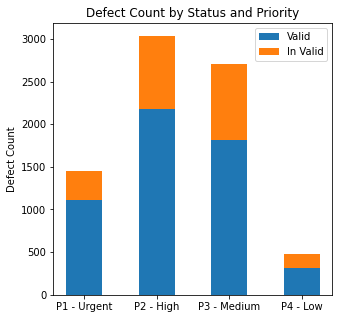

In [22]:
plt.figure(figsize=(5,5))
print("in")
Valid = Total_data.groupby(['Priority', 'Status'], group_keys=False).size().reset_index(name='count')
ind = np.arange(4)    # the x locations for the groups
width = 0.5 
p1 = plt.bar(ind, Valid[Valid.Status=='Valid']['count'], width)
p2 = plt.bar(ind, Valid[Valid.Status=='InValid']['count'], width,
             bottom=Valid[Valid.Status=='Valid']['count'])

plt.ylabel('Defect Count')
plt.title('Defect Count by Status and Priority')
plt.xticks(ind, Valid.Priority.unique())
plt.legend((p1[0], p2[0]), ('Valid', 'In Valid'))
print('out')
plt.show()

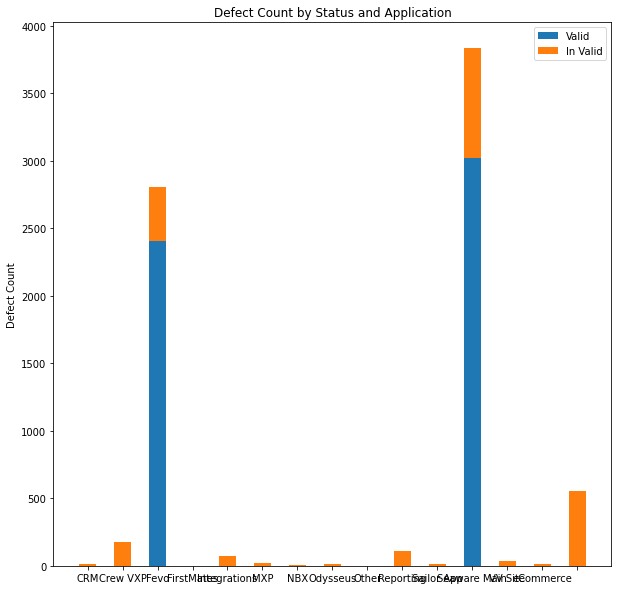

In [23]:
plt.figure(figsize=(10,10))
Valid = Total_data.groupby(['Application', 'Status'], group_keys=False).size().reset_index(name='count')# ['P3 - Medium', 'P2 - High', 'P1 - Urgent', 'P4 - Low']
ind = np.arange(15)   
width = 0.5
p1 = plt.bar(ind, [0,0,2408,0,0,0,0,0,0,0,0, 3019,0,0,0], width)
p2 = plt.bar(ind, [10,173,398,  1, 74, 20 ,8, 17,  1,108, 15,815, 36, 14,551], width,
             bottom=[0,0,2408,0,0,0,0,0,0,0,0, 3019,0,0,0])

plt.ylabel('Defect Count')
plt.title('Defect Count by Status and Application')
plt.xticks(ind, Valid.Application.unique())
plt.legend((p1[0], p2[0]), ('Valid', 'In Valid'))

plt.show()

## Data Cleansing

In [24]:
import string
import re

In [25]:
def commentsAppend(comment):
    comment_string = ''
    for i in range(len(comment)):
        comment_string = comment_string+' '+(comment[i]['body'])
    return comment_string

In [26]:
Total_data = pd.concat([valid_data, cancelled_data], ignore_index= True)
# Total_data = Total_data.reset_index(drop=True)

In [28]:
# Text Cleaning
Total_data['Description'] = Total_data.Description.apply(lambda x: re.sub('<[^<]+?>', '', x))
Total_data['Description'] = Total_data.Description.apply(lambda x: re.sub(r'https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))
Total_data['Description'] = Total_data.Description.apply(lambda x: re.sub(r'\]', ']\\n', x))
Total_data['Description'] = Total_data.Description.apply(lambda x: re.sub(r'\[\~accountid:.*[\r\n]*\]|\/', ' ', x))
Total_data['Description'] = Total_data.Description.apply(lambda x: re.sub("\n+\r", "", x))
# Total_data['Description'] = Total_data.Description.apply(lambda x: re.sub("\n|\r|\[|\]", "", x))
# Total_data['Description'] = Total_data.Description.apply(lambda x: re.sub("\r", "", x))
Total_data['Comments_new'] = Total_data.Comments.apply(lambda x: commentsAppend(x))
Total_data['Comments_new'] = Total_data.Comments_new.apply(lambda x: re.sub('<[^<]+?>', '', x))
Total_data['Comments_new'] = Total_data.Comments_new.apply(lambda x: re.sub(r'https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))
Total_data['Comments_new'] = Total_data.Comments_new.apply(lambda x: re.sub(r'\]', ']\\n', x))
Total_data['Comments_new'] = Total_data.Comments_new.apply(lambda x: re.sub(r'\[\~accountid:.*[\r\n]*\]|\/', ' ', x))
Total_data['Comments_new'] = Total_data.Comments_new.apply(lambda x: re.sub("\n|\r|\[|\]", "", x))
# Total_data.head()

## Modeling

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [30]:
x_train, x_test, y_train, y_test = train_test_split(Total_data[Total_data.columns[1:]], Total_data.Status, test_size =0.20, random_state =11915013)
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [31]:
#Count Vectorizer
count_vectorizer = CountVectorizer(analyzer='word',min_df=5, stop_words='english')
count_vectorizer.fit(x_train.Description) 
xtrain_count = count_vectorizer.transform(x_train.Description)
xtest_count = count_vectorizer.transform(x_test.Description)

# Tfidf Vectorization at word level
tfidf_vectorizer = TfidfVectorizer(analyzer='word',min_df=5, stop_words='english')
tfidf_vectorizer.fit(x_train.Description) 
xtrain_tfidf = tfidf_vectorizer.transform(x_train.Description)
xtest_tfidf = tfidf_vectorizer.transform(x_test.Description)

# Tfidf Vectorization at ngram level(of length 2 and 3)
tfidf_vectorizer_ngram = TfidfVectorizer(analyzer='word',ngram_range= (2,3), min_df=5, stop_words='english')
tfidf_vectorizer_ngram.fit(x_train.Description) 
xtrain_tfidf_ngram = tfidf_vectorizer_ngram.transform(x_train.Description)
xtest_tfidf_ngram = tfidf_vectorizer_ngram.transform(x_test.Description)


In [32]:
def ldaWeights(components, train_feature_vec, test_feature_vec):
    lda_model = LatentDirichletAllocation(n_components=components, learning_method='online', max_iter=20)
    lda_model.fit(train_feature_vec)
    lda_weights_train = lda_model.transform(train_feature_vec)
    lda_weights_test = lda_model.transform(test_feature_vec)
    return lda_weights_train, lda_weights_test

In [33]:
# Applying Supervised Models on Count Weights, TFIDF Weights and LDA weight matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [34]:
def ModelTraining(classifier, train_feature_vec, y_tra, test_feature_vec, y_tes, ModelName):
    classifier.fit(train_feature_vec, y_tra)
    train_pred = classifier.predict(train_feature_vec)
    test_pred = classifier.predict(test_feature_vec)
    train_met = precision_recall_fscore_support(y_tra, train_pred, average='weighted')
#     print("Train Metrics: ", precision_recall_fscore_support(y_train, train_pred, average='weighted'), accuracy_score( y_train, train_pred))
#     print("Test Metrics: ", precision_recall_fscore_support(y_test, test_pred, average='weighted'), accuracy_score( y_test, test_pred))
    return [ModelName, train_met[0], train_met[1], train_met[2], accuracy_score( y_tra, train_pred), accuracy_score( y_tes, test_pred)]

In [35]:
metricList = []
metricList.append(ModelTraining(MultinomialNB(), xtrain_count, y_train, xtest_count, y_test, 'MultinomialNB_CountVec'))
metricList.append(ModelTraining(MultinomialNB(), xtrain_tfidf, y_train, xtest_tfidf, y_test, 'MultinomialNB_TfIDFVec'))
metricList.append(ModelTraining(MultinomialNB(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test, 'MultinomialNB_TfIDFNgramVec'))
metricList.append(ModelTraining(LinearDiscriminantAnalysis(), xtrain_count.toarray(), y_train, xtest_count.toarray(), y_test, 'LinearDiscriminant_CountVec'))
metricList.append(ModelTraining(LinearDiscriminantAnalysis(), xtrain_tfidf.toarray(), y_train, xtest_tfidf.toarray(), y_test, 'LinearDiscriminant_TfIDFVec'))
metricList.append(ModelTraining(LinearDiscriminantAnalysis(), xtrain_tfidf_ngram.toarray(), y_train, xtest_tfidf_ngram.toarray(), y_test, 'LinearDiscriminant_TfIDFNgramVec'))
metricList.append(ModelTraining(DecisionTreeClassifier(),  xtrain_count, y_train, xtest_count, y_test, 'DecisionTree_CountVec'))
metricList.append(ModelTraining(DecisionTreeClassifier(), xtrain_tfidf, y_train, xtest_tfidf, y_test, 'DecisionTree_TfIDFVec'))
metricList.append(ModelTraining(DecisionTreeClassifier(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test, 'DecisionTree_TfIDFNgramVec'))
metricList.append(ModelTraining(SVC(),  xtrain_count, y_train, xtest_count, y_test, 'SupportVector_CountVec'))
metricList.append(ModelTraining(SVC(), xtrain_tfidf, y_train, xtest_tfidf, y_test, 'SupportVector_TfIDFVec'))
metricList.append(ModelTraining(SVC(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test, 'SupportVector_TfIDFNgramVec'))
metricList.append(ModelTraining(RandomForestClassifier(),  xtrain_count, y_train, xtest_count, y_test, 'RandomForest_CountVec'))
metricList.append(ModelTraining(RandomForestClassifier(), xtrain_tfidf, y_train, xtest_tfidf, y_test, 'RandomForest_TfIDFVec'))
metricList.append(ModelTraining(RandomForestClassifier(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test, 'RandomForest_TfIDFNgramVec'))
metricList.append(ModelTraining(GradientBoostingClassifier(),  xtrain_count, y_train, xtest_count, y_test, 'XGBoost_CountVec'))
metricList.append(ModelTraining(GradientBoostingClassifier(), xtrain_tfidf, y_train, xtest_tfidf, y_test, 'XGBoost_TfIDFVec'))
metricList.append(ModelTraining(GradientBoostingClassifier(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test, 'XGBoost_TfIDFNgramVec'))


In [36]:
MetricsDf = pd.DataFrame(metricList, columns=['Classifier', 'Precision', 'Recall', 'F1-Score', "TrainAcc", 'TestAcc'])
MetricsDf = MetricsDf[['Classifier', 'Precision', 'Recall', 'F1-Score', 'TrainAcc', 'TestAcc']]
MetricsDf.to_csv('/content/drive/My Drive/DMS/Metrics.csv')
MetricsDf

,Classifier,Precision,Recall,F1-Score,TrainAcc,TestAcc
0,MultinomialNB_CountVec,0.788049,0.787414,0.787724,0.787414,0.747066
1,MultinomialNB_TfIDFVec,0.812077,0.801761,0.774280,0.801761,0.797262
2,MultinomialNB_TfIDFNgramVec,0.835079,0.824584,0.804546,0.824584,0.798566
3,LinearDiscriminant_CountVec,0.926760,0.926638,0.925087,0.926638,0.685137
4,LinearDiscriminant_TfIDFVec,0.943060,0.943104,0.942296,0.943104,0.687093
5,LinearDiscriminant_TfIDFNgramVec,0.985087,0.984513,0.984608,0.984513,0.586050
6,DecisionTree_CountVec,0.996909,0.996903,0.996904,0.996903,0.721643
7,DecisionTree_TfIDFVec,0.996909,0.996903,0.996904,0.996903,0.704694
8,DecisionTree_TfIDFNgramVec,0.985779,0.985165,0.985261,0.985165,0.724250
9,SupportVector_CountVec,0.844620,0.809423,0.776023,0.809423,0.794654


+ Here we dont know no of topics to run above models on LDA topics
+ From Top2vec Labelling we can see total different topics were around 82. So lets try with 75, 80, 82 and 85 topics


In [37]:
LDAmetricList = []
train_weights, test_weights = ldaWeights(75, xtrain_count, xtest_count)
LDAmetricList.append(ModelTraining(MultinomialNB(), train_weights, y_train, test_weights, y_test, 'MultinomialNB_CountVec LDA 75'))
LDAmetricList.append(ModelTraining(LinearDiscriminantAnalysis(), train_weights, y_train, test_weights, y_test, 'LinearDiscriminant_CountVec LDA 75'))
LDAmetricList.append(ModelTraining(DecisionTreeClassifier(), train_weights, y_train, test_weights, y_test, 'DecisionTree_CountVec LDA 75'))
LDAmetricList.append(ModelTraining(SVC(),  train_weights, y_train, test_weights, y_test, 'SupportVector_CountVec LDA 75'))
LDAmetricList.append(ModelTraining(RandomForestClassifier(), train_weights, y_train, test_weights, y_test, 'RandomForest_CountVec LDA 75'))
LDAmetricList.append(ModelTraining(GradientBoostingClassifier(),  train_weights, y_train, test_weights, y_test, 'XGBoost_CountVec LDA 75'))

train_weights, test_weights = ldaWeights(80, xtrain_count, xtest_count)
LDAmetricList.append(ModelTraining(MultinomialNB(), train_weights, y_train, test_weights, y_test, 'MultinomialNB_CountVec LDA 80'))
LDAmetricList.append(ModelTraining(LinearDiscriminantAnalysis(), train_weights, y_train, test_weights, y_test, 'LinearDiscriminant_CountVec LDA 80'))
LDAmetricList.append(ModelTraining(DecisionTreeClassifier(), train_weights, y_train, test_weights, y_test, 'DecisionTree_CountVec LDA 80'))
LDAmetricList.append(ModelTraining(SVC(),  train_weights, y_train, test_weights, y_test, 'SupportVector_CountVec LDA 80'))
LDAmetricList.append(ModelTraining(RandomForestClassifier(), train_weights, y_train, test_weights, y_test, 'RandomForest_CountVec LDA 80'))
LDAmetricList.append(ModelTraining(GradientBoostingClassifier(),  train_weights, y_train, test_weights, y_test, 'XGBoost_CountVec LDA 80'))

train_weights, test_weights = ldaWeights(82, xtrain_count, xtest_count)
LDAmetricList.append(ModelTraining(MultinomialNB(), train_weights, y_train, test_weights, y_test, 'MultinomialNB_CountVec LDA 82'))
LDAmetricList.append(ModelTraining(LinearDiscriminantAnalysis(), train_weights, y_train, test_weights, y_test, 'LinearDiscriminant_CountVec LDA 82'))
LDAmetricList.append(ModelTraining(DecisionTreeClassifier(), train_weights, y_train, test_weights, y_test, 'DecisionTree_CountVec LDA 82'))
LDAmetricList.append(ModelTraining(SVC(),  train_weights, y_train, test_weights, y_test, 'SupportVector_CountVec LDA 82'))
LDAmetricList.append(ModelTraining(RandomForestClassifier(), train_weights, y_train, test_weights, y_test, 'RandomForest_CountVec LDA 82'))
LDAmetricList.append(ModelTraining(GradientBoostingClassifier(),  train_weights, y_train, test_weights, y_test, 'XGBoost_CountVec LDA 82'))

train_weights, test_weights = ldaWeights(85, xtrain_count, xtest_count)
LDAmetricList.append(ModelTraining(MultinomialNB(), train_weights, y_train, test_weights, y_test, 'MultinomialNB_CountVec LDA 85'))
LDAmetricList.append(ModelTraining(LinearDiscriminantAnalysis(), train_weights, y_train, test_weights, y_test, 'LinearDiscriminant_CountVec LDA 85'))
LDAmetricList.append(ModelTraining(DecisionTreeClassifier(), train_weights, y_train, test_weights, y_test, 'DecisionTree_CountVec LDA 85'))
LDAmetricList.append(ModelTraining(SVC(),  train_weights, y_train, test_weights, y_test, 'SupportVector_CountVec LDA 85'))
LDAmetricList.append(ModelTraining(RandomForestClassifier(), train_weights, y_train, test_weights, y_test, 'RandomForest_CountVec LDA 85'))
LDAmetricList.append(ModelTraining(GradientBoostingClassifier(),  train_weights, y_train, test_weights, y_test, 'XGBoost_CountVec LDA 85'))

In [ ]:
train_weights, test_weights = ldaWeights(75, xtrain_tfidf, xtest_tfidf)
LDAmetricList.append(ModelTraining(MultinomialNB(), train_weights, y_train, test_weights, y_test, 'MultinomialNB_TfIDFVec LDA 75'))
LDAmetricList.append(ModelTraining(LinearDiscriminantAnalysis(), train_weights, y_train, test_weights, y_test, 'LinearDiscriminant_TfIDFVec LDA 75'))
LDAmetricList.append(ModelTraining(DecisionTreeClassifier(), train_weights, y_train, test_weights, y_test, 'DecisionTree_TfIDFVec LDA 75'))
LDAmetricList.append(ModelTraining(SVC(),  train_weights, y_train, test_weights, y_test, 'SupportVector_TfIDFVec LDA 75'))
LDAmetricList.append(ModelTraining(RandomForestClassifier(), train_weights, y_train, test_weights, y_test, 'RandomForest_TfIDFVec LDA 75'))
LDAmetricList.append(ModelTraining(GradientBoostingClassifier(),  train_weights, y_train, test_weights, y_test, 'XGBoost_TfIDFVec LDA 75'))

train_weights, test_weights = ldaWeights(80, xtrain_tfidf, xtest_tfidf)
LDAmetricList.append(ModelTraining(MultinomialNB(), train_weights, y_train, test_weights, y_test, 'MultinomialNB_TfIDFVec LDA 80'))
LDAmetricList.append(ModelTraining(LinearDiscriminantAnalysis(), train_weights, y_train, test_weights, y_test, 'LinearDiscriminant_TfIDFVec LDA 80'))
LDAmetricList.append(ModelTraining(DecisionTreeClassifier(), train_weights, y_train, test_weights, y_test, 'DecisionTree_TfIDFVec LDA 80'))
LDAmetricList.append(ModelTraining(SVC(),  train_weights, y_train, test_weights, y_test, 'SupportVector_TfIDFVec LDA 80'))
LDAmetricList.append(ModelTraining(RandomForestClassifier(), train_weights, y_train, test_weights, y_test, 'RandomForest_TfIDFVec LDA 80'))
LDAmetricList.append(ModelTraining(GradientBoostingClassifier(),  train_weights, y_train, test_weights, y_test, 'XGBoost_TfIDFVec LDA 80'))

train_weights, test_weights = ldaWeights(82, xtrain_tfidf, xtest_tfidf)
LDAmetricList.append(ModelTraining(MultinomialNB(), train_weights, y_train, test_weights, y_test, 'MultinomialNB_TfIDFVec LDA 82'))
LDAmetricList.append(ModelTraining(LinearDiscriminantAnalysis(), train_weights, y_train, test_weights, y_test, 'LinearDiscriminant_TfIDFVec LDA 82'))
LDAmetricList.append(ModelTraining(DecisionTreeClassifier(), train_weights, y_train, test_weights, y_test, 'DecisionTree_TfIDFVec LDA 82'))
LDAmetricList.append(ModelTraining(SVC(),  train_weights, y_train, test_weights, y_test, 'SupportVector_TfIDFVec LDA 82'))
LDAmetricList.append(ModelTraining(RandomForestClassifier(), train_weights, y_train, test_weights, y_test, 'RandomForest_TfIDFVec LDA 82'))
LDAmetricList.append(ModelTraining(GradientBoostingClassifier(),  train_weights, y_train, test_weights, y_test, 'XGBoost_TfIDFVec LDA 82'))

train_weights, test_weights = ldaWeights(85, xtrain_tfidf, xtest_tfidf)
LDAmetricList.append(ModelTraining(MultinomialNB(), train_weights, y_train, test_weights, y_test, 'MultinomialNB_TfIDFVec LDA 85'))
LDAmetricList.append(ModelTraining(LinearDiscriminantAnalysis(), train_weights, y_train, test_weights, y_test, 'LinearDiscriminant_TfIDFVec LDA 85'))
LDAmetricList.append(ModelTraining(DecisionTreeClassifier(), train_weights, y_train, test_weights, y_test, 'DecisionTree_TfIDFVec LDA 85'))
LDAmetricList.append(ModelTraining(SVC(),  train_weights, y_train, test_weights, y_test, 'SupportVector_TfIDFVec LDA 85'))
LDAmetricList.append(ModelTraining(RandomForestClassifier(), train_weights, y_train, test_weights, y_test, 'RandomForest_TfIDFVec LDA 85'))
LDAmetricList.append(ModelTraining(GradientBoostingClassifier(),  train_weights, y_train, test_weights, y_test, 'XGBoost_TfIDFVec LDA 85'))

In [38]:
LDAMetricDF = pd.DataFrame(LDAmetricList, columns=['Classifier', 'Precision', 'Recall', 'F1-Score', "TrainAcc", 'TestAcc'])
LDAMetricDF= LDAMetricDF[['Classifier', 'Precision', 'Recall', 	'F1-Score',	'TrainAcc',	'TestAcc']]
LDAMetricDF.to_csv('/content/drive/My Drive/DMS/LDAMetrics.csv')
LDAMetricDF

,Classifier,Precision,Recall,F1-Score,TrainAcc,TestAcc
0,MultinomialNB_CountVec LDA 75,0.793096,0.717150,0.608416,0.717150,0.722295
1,LinearDiscriminant_CountVec LDA 75,0.761175,0.767199,0.733272,0.767199,0.771186
2,DecisionTree_CountVec LDA 75,0.996909,0.996903,0.996904,0.996903,0.692308
3,SupportVector_CountVec LDA 75,0.813343,0.792631,0.756867,0.792631,0.789439
4,RandomForest_CountVec LDA 75,0.996905,0.996903,0.996900,0.996903,0.775750
5,XGBoost_CountVec LDA 75,0.813425,0.799478,0.769433,0.799478,0.784224
6,MultinomialNB_CountVec LDA 80,0.794270,0.724976,0.625939,0.724976,0.728814
7,LinearDiscriminant_CountVec LDA 80,0.770852,0.774861,0.743996,0.774861,0.779009
8,DecisionTree_CountVec LDA 80,0.996909,0.996903,0.996904,0.996903,0.718383
9,SupportVector_CountVec LDA 80,0.815102,0.801924,0.773191,0.801924,0.794654


From the above Different Traditional classification algorithms metrics we can see,
+ Almost all the models were overfitted for the train Data.
+ Of these above models Multinomial Naive Bayes is trying to learn the pattern/ generalised bias. 

Let's try to apply tune the hyper parameters of other models on TfIDF embeddings, Since .
+ TFIDF represntation weighted for information content compared to count vectorization.
+ TfIDF will increase the dimensionality and here we are trying to tune the models overfitting.  


#### Ignoring the parameter tuning of below LDA model here. The defulit Assumptions
1. Bayes ditribution of each feature reasonable.
2. Solver Defulat value of svd(Singular value decompostion) as covariance matrix claculation requires heavy compution powers for large feature calsification problem 


Decision Tree Clasisifcation can be tuned from overfitting on the training Data. Here i have changed hyper parameters and the Best performance was observed with below values 
1. criterion= "entropy", 
2. max_depth=15
3. min_samples_split=0.3

And Metris (Precision,	Recall,	F1-Score,	TrainAcc and 	TestAcc) were 
0.7582047194744831, 0.7588849038148028, 0.7142473331089735, 0.7588849038148028, 0.7685788787483703.



In Support Machine classifier, tuned 
+ C(Cost for labeling a class wrongly), Not much imppact with reducing cost value. 
+ Kenrel (Shape of separation boundary ) Giving better results with Defulat Linear value itself.

So here i am going with default values of C = i*0.1, kernel = 'linear') and metrics(Precision, Recall, F1-Score, TrainAcc and TestAcc) were
 0.8613050412001815, 0.8461036843821323, 0.829644250055557, 0.8461036843821323, 0.8024771838331161

Random forest Clasisifcation ensemble version of Decision trees, so tuned n_estimator on top of decision tree params. Best results params. 

criterion= "entropy",
max_depth=15
min_samples_split=0.3
n_estimator = 50 
And Metris (Precision, Recall, F1-Score, TrainAcc and TestAcc) were 0.7582047194744831, 0.7588849038148028, 0.7142473331089735, 0.7588849038148028, 0.7685788787483703.

In [ ]:
# ModelTraining(MultinomialNB(), xtrain_tfidf, y_train, xtest_tfidf, y_test, 'MultinomialNB_TfIDFVec')
# ModelTraining(LinearDiscriminantAnalysis(), xtrain_tfidf.toarray(), y_train, xtest_tfidf.toarray(), y_test, 'LinearDiscriminant_TfIDFVec')
# ModelTraining(DecisionTreeClassifier(criterion= "entropy", max_depth=15, min_samples_split=0.3), xtrain_tfidf, y_train, xtest_tfidf, y_test, 'DecisionTree_TfIDFVec')
# 'DecisionTree_TfIDFVec', 0.7582047194744831, 0.7588849038148028, 0.7142473331089735, 0.7588849038148028, 0.7685788787483703
# ModelTraining(SVC(C = i*0.1, kernel = 'linear'), xtrain_tfidf, y_train, xtest_tfidf, y_test, 'SupportVector_TfIDFVec')
# ['SupportVector_TfIDFVec', 0.8613050412001815, 0.8461036843821323, 0.829644250055557, 0.8461036843821323, 0.8024771838331161]
# ModelTraining(RandomForestClassifier(n_estimators=50, criterion= "entropy", max_depth=15, min_samples_split=0.30, random_state=11915013), xtrain_tfidf, y_train, xtest_tfidf, y_test, 'RandomForest_TfIDFVec')
# 'RandomForest_TfIDFVec', 0.8001534575859348, 0.7262797522008477, 0.6282082248652229, 0.7262797522008477, 0.7288135593220338
# ModelTraining(GradientBoostingClassifier(learning_rate=0.25, subsample = 0.8, random_state=11915013), xtrain_tfidf, y_train, xtest_tfidf, y_test, 'XGBoost_TfIDFVec')
# 'XGBoost_TfIDFVec', 0.8620969051522372, 0.8534398434952722, 0.8407657584694119, 0.8534398434952722, 0.7868318122555411

##Final Model
Trained the Multinomial Navie Bayes on Total available data and saved the model files on the drive for deployment. 


In [39]:
# Final Model
tfidf_vectorizer = TfidfVectorizer(analyzer='word',min_df=5, stop_words='english')
tfidf_vectorizer.fit(Total_data.Description)

# pickle.dump(tfidf_vectorizer,open("tfidf.pkl","wb"))
tfidf_total = tfidf_vectorizer.transform(Total_data.Description)

randforest = RandomForestClassifier(criterion = 'entropy')
randforest.fit(tfidf_total, Total_data.Status)
train_pred = randforest.predict(tfidf_total)
print("Train Metrics: ", precision_recall_fscore_support(Total_data.Status, train_pred, average='weighted'), accuracy_score( Total_data.Status, train_pred))
# print("Test Metrics: ", precision_recall_fscore_support(y_test, test_pred, average='weighted'), accuracy_score( y_test, test_pred))

mnb = MultinomialNB()
mnb.fit(tfidf_total, Total_data.Status)
train_pred = mnb.predict(tfidf_total)
print("Train Metrics: ", precision_recall_fscore_support(Total_data.Status, train_pred, average='weighted'), accuracy_score( Total_data.Status, train_pred))
# pickle.dump(mnb,open("MNBModel.pkl","wb"))

Train Metrics:  (0.9955706967228276, 0.995565988523735, 0.9955601288770305, None) 0.995565988523735
Train Metrics:  (0.8146878944446012, 0.8043818466353677, 0.777886892704062, None) 0.8043818466353677


In [ ]:
## End of the code